In [134]:
import jax
from flax import nnx
import jax.numpy as jnp

In [135]:
# Import additional libraries for data loading and training
from datasets import load_dataset, Dataset
import numpy as np
import optax
from tqdm import tqdm
from typing import Optional, Callable

In [136]:
jax.devices()

[CudaDevice(id=0)]

In [137]:
data_dir = "./data"
# Load CIFAR-10 dataset
dataset = load_dataset("uoft-cs/cifar10", cache_dir=data_dir)
dataset = dataset.with_format("jax")
train_data = dataset["train"]
test_data = dataset["test"]
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

print(train_data.features)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Sample shape: {train_data[0]['img'].shape}")

data_dim = train_data[0]["img"].shape[0] * train_data[0]["img"].shape[1] * train_data[0]["img"].shape[2]


{'img': Image(mode=None, decode=True), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
Train samples: 50000
Test samples: 10000
Sample shape: (32, 32, 3)


In [138]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5

In [139]:
from typing import SupportsIndex, TypedDict
import grain.python as grain
import jax.numpy as jnp


seed = 12
val_batch_size = 2 * BATCH_SIZE


def preprocess(image: jnp.ndarray, rng: np.random.Generator) -> jnp.ndarray:
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Flatten the image
    return image
    
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

train_grain_dataset = grain.MapDataset.source(train_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=BATCH_SIZE)

test_grain_dataset = grain.MapDataset.source(test_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=val_batch_size)

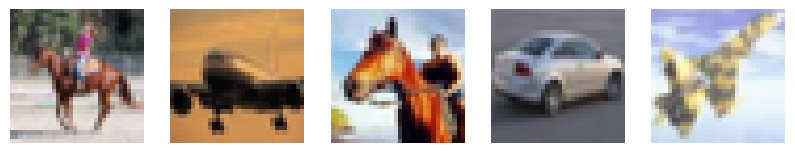

In [140]:
# Display 5 samples from the training dataset
import matplotlib.pyplot as plt

example_batch = next(iter(train_grain_dataset))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(example_batch[i].reshape(32, 32, 3))
    axes[i].axis('off')
plt.show()

In [141]:
def get_norm_layer(norm_type, features, rngs: nnx.Rngs) -> Callable[[jax.Array], jax.Array]:
    """Normalization layer."""
    if norm_type == 'BN':
        raise NotImplementedError
    elif norm_type == 'LN':
        norm_fn = nnx.LayerNorm(num_features=features, rngs=rngs)
    elif norm_type == 'GN':
        norm_fn = nnx.GroupNorm(num_features=features, rngs=rngs)
    else:
        raise NotImplementedError
    return norm_fn


def tensorflow_style_avg_pooling(x, window_shape, strides, padding: str):
    pool_sum = jax.lax.reduce_window(x, 0.0, jax.lax.add,
                                   (1,) + window_shape + (1,),
                                   (1,) + strides + (1,), padding)
    pool_denom = jax.lax.reduce_window(
        jnp.ones_like(x), 0.0, jax.lax.add, (1,) + window_shape + (1,),
        (1,) + strides + (1,), padding)
    return pool_sum / pool_denom

def upsample_2d(x: jax.Array, factor: int = 2) -> jax.Array:
    n, h, w, c = x.shape
    x = jax.image.resize(x, (n, h * factor, w * factor, c), method='nearest')
    return x

def downsample_2d(x: jax.Array) -> jax.Array:
    return tensorflow_style_avg_pooling(x, (2, 2), strides=(2, 2), padding='same')

def squared_euclidean_distance(a: jnp.ndarray,
                               b: jnp.ndarray,
                               b2: Optional[jnp.ndarray] = None) -> jnp.ndarray:
    """Computes the pairwise squared Euclidean distance.

    Args:
        a: float32: (n, d): An array of points.
        b: float32: (m, d): An array of points.
        b2: float32: (d, m): b square transpose.

    Returns:
        d: float32: (n, m): Where d[i, j] is the squared Euclidean distance between
        a[i] and b[j].
    """
    if b2 is None:
        b2 = jnp.sum(b.T**2, axis=0, keepdims=True)
    a2 = jnp.sum(a**2, axis=1, keepdims=True)
    ab = jnp.matmul(a, b.T)
    d = a2 - 2 * ab + b2
    return d

def entropy_loss_fn(affinity, loss_type="softmax", temperature=1.0):
    """Calculates the entropy loss. Affinity is the similarity/distance matrix."""
    flat_affinity = affinity.reshape(-1, affinity.shape[-1])
    flat_affinity /= temperature
    probs = jax.nn.softmax(flat_affinity, axis=-1)
    log_probs = jax.nn.log_softmax(flat_affinity + 1e-5, axis=-1)
    if loss_type == "softmax":
        target_probs = probs
    elif loss_type == "argmax":
        codes = jnp.argmax(flat_affinity, axis=-1)
        onehots = jax.nn.one_hot(
            codes, flat_affinity.shape[-1], dtype=flat_affinity.dtype)
        onehots = probs - jax.lax.stop_gradient(probs - onehots)
        target_probs = onehots
    else:
        raise ValueError("Entropy loss {} not supported".format(loss_type))
    avg_probs = jnp.mean(target_probs, axis=0)
    avg_entropy = -jnp.sum(avg_probs * jnp.log(avg_probs + 1e-5))
    sample_entropy = -jnp.mean(jnp.sum(target_probs * log_probs, axis=-1))
    loss = sample_entropy - avg_entropy
    return loss

def sg(x):
    return jax.lax.stop_gradient(x)


In [142]:
class ResBlock(nnx.Module):
    """Basic Residual Block."""
    norm_1: Callable[[jax.Array], jax.Array]
    activation_fn1: Callable[[jax.Array], jax.Array]
    conv_1: nnx.Conv
    norm_2: Callable[[jax.Array], jax.Array]
    activation_fn2: Callable[[jax.Array], jax.Array]
    conv_2: nnx.Conv
    residual_conv: nnx.Conv
    in_features: int
    out_features: int

    
    def __init__(self, in_features, out_features, norm_type, activation_fn, rngs: nnx.Rngs):
        self.in_features = in_features
        self.out_features = out_features
        self.norm_1 = get_norm_layer(norm_type, in_features, rngs)
        self.activation_fn1 = activation_fn
        self.conv_1 = nnx.Conv(in_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.norm_2 = get_norm_layer(norm_type, out_features, rngs)
        self.activation_fn2 = activation_fn
        self.conv_2 = nnx.Conv(out_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.residual_conv = nnx.Conv(in_features, kernel_size=(1, 1), use_bias=False, out_features=out_features, rngs=rngs)

    def __call__(self, x):
        input_dim = x.shape[-1]
        residual = x
        x= self.norm_1(x)
        x= self.activation_fn1(x)
        x= self.conv_1(x)
        x= self.norm_2(x)
        x= self.activation_fn2(x)
        x= self.conv_2(x)

        if input_dim != x.shape[-1]:
            residual = self.residual_conv(residual)
        
        return x + residual
    
def multi_resblock(num_blocks, in_features, out_features, norm_type, activation_fn, rngs: nnx.Rngs) -> nnx.Sequential:
    return nnx.Sequential(*[
        ResBlock(
            in_features=in_features if i == 0 else out_features,
            out_features=out_features,
            norm_type=norm_type,
            activation_fn=activation_fn,
            rngs=rngs)
        for i in range(num_blocks)
    ])

class Encoder(nnx.Module):
    """From [H,W,D] image to [H',W',D'] embedding. Using Conv layers."""

    norm_layer: Callable[[jax.Array], jax.Array]
    initial_conv: nnx.Conv
    activation_fn: Callable[[jax.Array], jax.Array]
    blocks: nnx.Sequential
    final_res_blocks: nnx.Sequential
    last_conv: nnx.Conv

    def __init__(self, filters, num_res_blocks, channel_multipliers, embedding_dim, norm_type, quantizer_type, image_channels, rngs: nnx.Rngs, activation_fn=nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters * channel_multipliers[-1], rngs)
        self.activation_fn = activation_fn

        self.initial_conv = nnx.Conv(kernel_size=(3, 3), use_bias=False, in_features=image_channels, out_features=filters, rngs=rngs)

        self.blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    out_features=filters * channel_multipliers[i],
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs),
                # Add downsample layer if not the last block
                *([] if i == len(channel_multipliers) - 1 else [lambda x: downsample_2d(x)])
            )
            for i in range(len(channel_multipliers))
        ])

        # Then add the final res blocks
        self.final_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)
        
        last_dim = embedding_dim*2 if quantizer_type == 'kl' else embedding_dim
        self.last_conv = nnx.Conv(filters * channel_multipliers[-1], kernel_size=(1, 1), use_bias=False, out_features=last_dim, rngs=rngs)
        

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.blocks(x)

        x = self.final_res_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)

        x = self.last_conv(x)

        return x
    
class Decoder(nnx.Module):
    """From [H',W',D'] embedding to [H,W,D] embedding. Using Conv layers."""

    def __init__(self, embedding_dim, filters, num_res_blocks, channel_multipliers, image_channels, norm_type, rngs: nnx.Rngs, activation_fn=nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters, rngs)
        self.activation_fn = activation_fn
        self.initial_conv = nnx.Conv(in_features=embedding_dim, kernel_size=(3, 3), use_bias=True, out_features=filters * channel_multipliers[-1], rngs=rngs)


        self.initial_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)

        # Decoder blocks with upsampling
        self.decoder_blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i],
                    out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs)
                ,
                # Add upsample_2d + conv if not the first block (i > 0)
                *([] if i == 0 else [
                    lambda x: upsample_2d(x, 2),
                    nnx.Conv(
                        in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        kernel_size=(3, 3),
                        rngs=rngs)
                ])
            )
            for i in reversed(range(len(channel_multipliers)))
        ])
        self.final_conv = nnx.Conv(in_features=filters, out_features=image_channels, kernel_size=(3, 3), rngs=rngs)

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_res_blocks(x)
        x = self.decoder_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)
        x = self.final_conv(x)
        
        return x

In [ ]:
from flax import nnx
import jax.numpy as jnp
import jax
 
class VectorQuantizerCodebook(nnx.Param): pass

class VectorQuantizer(nnx.Module):
    """Basic vector quantizer."""
    deterministic: bool = False
    codebook: VectorQuantizerCodebook

    def __init__(self, codebook_size, embedding_dim, commitment_cost, entropy_loss_type, entropy_loss_ratio, entropy_temperature, rngs: nnx.Rngs):
        codebook_initializer = nnx.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        self.codebook = VectorQuantizerCodebook(
            codebook_initializer(rngs.params(), shape =(codebook_size, embedding_dim))
        )
        self.commitment_cost = commitment_cost
        self.entropy_loss_type = entropy_loss_type
        self.entropy_loss_ratio = entropy_loss_ratio
        self.entropy_temperature = entropy_temperature

    def __call__(self, x: jax.Array):
        codebook = jnp.asarray(self.codebook) # (codebook_size, embedding_dim)
        codebook_size = codebook.shape[0]
        embedding_dim = codebook.shape[1]
        distances = jnp.reshape(
            squared_euclidean_distance(jnp.reshape(x, (-1, embedding_dim)), codebook),
            x.shape[:-1] + (codebook_size,)) # [x, codebook_size] similarity matrix.
        encoding_indices = jnp.argmin(distances, axis=-1)
        encoding_onehot = jax.nn.one_hot(encoding_indices, codebook_size)
        quantized = self.quantize(encoding_onehot)
        result_dict = dict()
        if not self.deterministic:
            e_latent_loss = jnp.mean((sg(quantized) - x)**2) * self.commitment_cost
            q_latent_loss = jnp.mean((quantized - sg(x))**2)
            entropy_loss = 0.0
            if self.entropy_loss_ratio != 0:
                entropy_loss = entropy_loss_fn(
                    -distances,
                    loss_type=self.entropy_loss_type,
                    temperature=self.entropy_temperature
                ) * self.entropy_loss_ratio
            e_latent_loss = jnp.asarray(e_latent_loss, jnp.float32)
            q_latent_loss = jnp.asarray(q_latent_loss, jnp.float32)
            entropy_loss = jnp.asarray(entropy_loss, jnp.float32)
            loss = e_latent_loss + q_latent_loss + entropy_loss
            result_dict = dict(
                quantizer_loss=loss,
                e_latent_loss=e_latent_loss,
                q_latent_loss=q_latent_loss,
                entropy_loss=entropy_loss)
            quantized = x + jax.lax.stop_gradient(quantized - x)

        result_dict.update({
            "z_ids": encoding_indices,
        })
        return quantized, result_dict

    def quantize(self, encoding_onehot: jnp.ndarray) -> jnp.ndarray:
        return jnp.dot(encoding_onehot, self.codebook.value)

    def decode_ids(self, ids: jnp.ndarray) -> jnp.ndarray:
        return jnp.take(self.codebook.value, ids, axis=0)



class Config(TypedDict):
    codebook_size: int
    embedding_dim: int
    commitment_cost: float
    entropy_loss_type: str
    entropy_loss_ratio: float
    entropy_temperature: float
    filters: int
    num_res_blocks: int
    channel_multipliers: list[int]
    norm_type: str
    quantizer_type: str
    image_channels: int


class VQVAE(nnx.Module):
    """VQVAE model."""
    quantizer: VectorQuantizer
    encoder: Encoder
    decoder: Decoder
    rngs: nnx.Rngs

    def __init__(self, config: Config, rngs: nnx.Rngs):
        """VQVAE setup."""
        self.quantizer = VectorQuantizer(
            codebook_size = config['codebook_size'],
            embedding_dim = config['embedding_dim'],
            commitment_cost = config['commitment_cost'],
            entropy_loss_type = config['entropy_loss_type'],
            entropy_loss_ratio = config['entropy_loss_ratio'],
            entropy_temperature = config['entropy_temperature'],
            rngs = rngs
        )
        self.encoder = Encoder(
            filters = config['filters'],
            num_res_blocks =config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            embedding_dim = config['embedding_dim'],
            norm_type=config['norm_type'],
            quantizer_type = config['quantizer_type'],
            image_channels = config['image_channels'],
            rngs = rngs
        )
        self.decoder = Decoder(
            embedding_dim = config['embedding_dim'],
            filters = config['filters'],
            num_res_blocks = config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            image_channels = config['image_channels'],
            norm_type=config['norm_type'],
            rngs = rngs
        )
        self.rngs = rngs

    def encode(self, image):
        encoded_feature = self.encoder(image)
        quantized, result_dict = self.quantizer(encoded_feature)
        return quantized, result_dict

    def decode(self, z_vectors):
        reconstructed = self.decoder(z_vectors)
        return reconstructed

    def decode_from_indices(self, z_ids):
        z_vectors = self.quantizer.decode_ids(z_ids)
        reconstructed_image = self.decode(z_vectors)
        return reconstructed_image

    def encode_to_indices(self, image):
        encoded_feature = self.encoder(image)
        _, result_dict = self.quantizer(encoded_feature)
        ids = result_dict["z_ids"]
        return ids

    def __call__(self, input_dict):
        quantized, result_dict = self.encode(input_dict)
        outputs = self.decoder(quantized)
        return outputs, result_dict

In [144]:

# Initialize model and optimizer
rngs = nnx.Rngs(0)
config = Config({
    "codebook_size": 512,
    "embedding_dim": 64,
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "standard",
    "image_channels": 3,
})
model = VQVAE(config=config,rngs=rngs)
optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)

print("Model initialized:", model)

Model initialized: VQVAE( # Param: 37,007,235 (148.0 MB), VectorQuantizerCodebook: 32,768 (131.1 KB), RngState: 2 (12 B), Total: 37,040,005 (148.2 MB)
  quantizer=VectorQuantizer( # VectorQuantizerCodebook: 32,768 (131.1 KB)
    codebook=VectorQuantizerCodebook( # 32,768 (131.1 KB)
      value=Array(shape=(512, 64), dtype=dtype('float32'))
    ),
    commitment_cost=0.25,
    entropy_loss_type='softmax',
    entropy_loss_ratio=0.0,
    entropy_temperature=1.0
  ),
  encoder=Encoder( # Param: 21,445,248 (85.8 MB)
    norm_layer=LayerNorm( # Param: 1,024 (4.1 KB)
      scale=Param( # 512 (2.0 KB)
        value=Array(shape=(512,), dtype=dtype('float32'))
      ),
      bias=Param( # 512 (2.0 KB)
        value=Array(shape=(512,), dtype=dtype('float32'))
      ),
      num_features=512,
      epsilon=1e-06,
      dtype=None,
      param_dtype=float32,
      use_bias=True,
      use_scale=True,
      bias_init=<function zeros at 0x7efef2844900>,
      scale_init=<function ones at 0x7efef289a

In [145]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [146]:
# Define loss function
def mse_loss(model, x):
    """Mean squared error reconstruction loss"""
    x_reconstructed, _ = model(x)
    return jnp.mean((x - x_reconstructed) ** 2)

def total_loss(model, x):
    """Total loss including reconstruction and quantizer losses"""
    x_reconstructed, result_dict = model(x)
    recon_loss = jnp.mean((x - x_reconstructed) ** 2)
    quantizer_loss = result_dict.get('quantizer_loss', 0.0)
    return recon_loss + quantizer_loss

@nnx.jit
def train_step(model, optimizer, x):
    """Single training step"""
    loss, grads = nnx.value_and_grad(mse_loss)(model, x)
    
    # Update with BOTH model and grads
    optimizer.update(grads=grads, model=model) 
    return loss

In [147]:
total_steps = len(train_data) // BATCH_SIZE
bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


model.train()
# Training loop
for epoch in range(NUM_EPOCHS):
    epoch_losses = []
    
    # Create progress bar
    with tqdm(
        desc=f"[train] epoch: {epoch}/{NUM_EPOCHS}, ",
        total=total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_grain_dataset:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)
        
    
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

[train] epoch: 0/5, [0/390] [00:00<?]

[train] epoch: 0/5, [391/?], loss=0.0628 [01:57<00:00]  
/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/5 - Average Loss: nan


[train] epoch: 1/5, [391/?], loss=0.0628 [01:20<00:00]  


Epoch 2/5 - Average Loss: nan


[train] epoch: 2/5, [391/?], loss=0.0624 [01:20<00:00]  


Epoch 3/5 - Average Loss: nan


[train] epoch: 3/5, [252/390], loss=0.0613 [00:52<00:29]


KeyboardInterrupt: 

In [148]:
model.eval()

# Evaluate on test set
test_losses = []
with tqdm(
    desc=f"[test] ",
    total=len(test_data) // val_batch_size,
    bar_format=bar_format,
    leave=True,
) as pbar:
    for batch_x in test_grain_dataset:
        loss = mse_loss(model, batch_x)
        test_losses.append(float(loss))
        pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)

avg_test_loss = np.mean(test_losses)
print(f"Test Loss: {avg_test_loss:.4f}")

[test] [40/?], loss=0.0792 [00:17<00:00] 

Test Loss: 0.0628


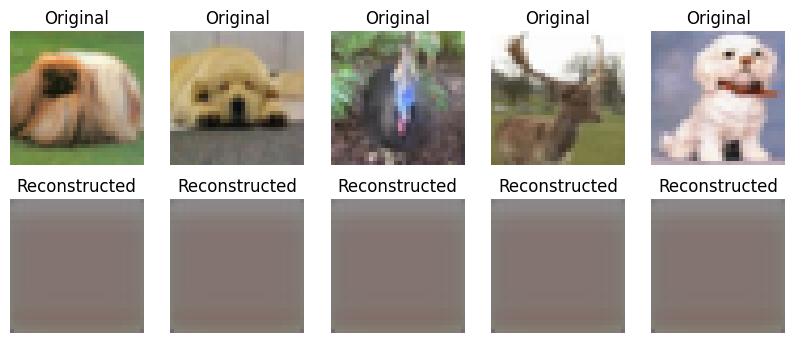

In [149]:
# Plot some reconstructed images
import matplotlib.pyplot as plt
num_images = 5
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
for i, batch_x in enumerate(test_grain_dataset):
    reconstructed, _ = model(batch_x)
    for j in range(num_images):
        if i * num_images + j >= len(test_grain_dataset):
            break
        # Original image
        axes[0, j].imshow(batch_x[j].reshape(32, 32, 3), cmap='gray')
        axes[0, j].axis('off')
        if i == 0:
            axes[0, j].set_title("Original")
        
        # Reconstructed image
        axes[1, j].imshow(reconstructed[j].reshape(32, 32, 3), cmap='gray')
        axes[1, j].axis('off')
        if i == 0:
            axes[1, j].set_title("Reconstructed")
    break  # Only plot first batch